In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:12<00:00, 190MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import glob
import cv2
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, InputLayer, AveragePooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [4]:
path

'/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2'

# NOrmal Images : 1341


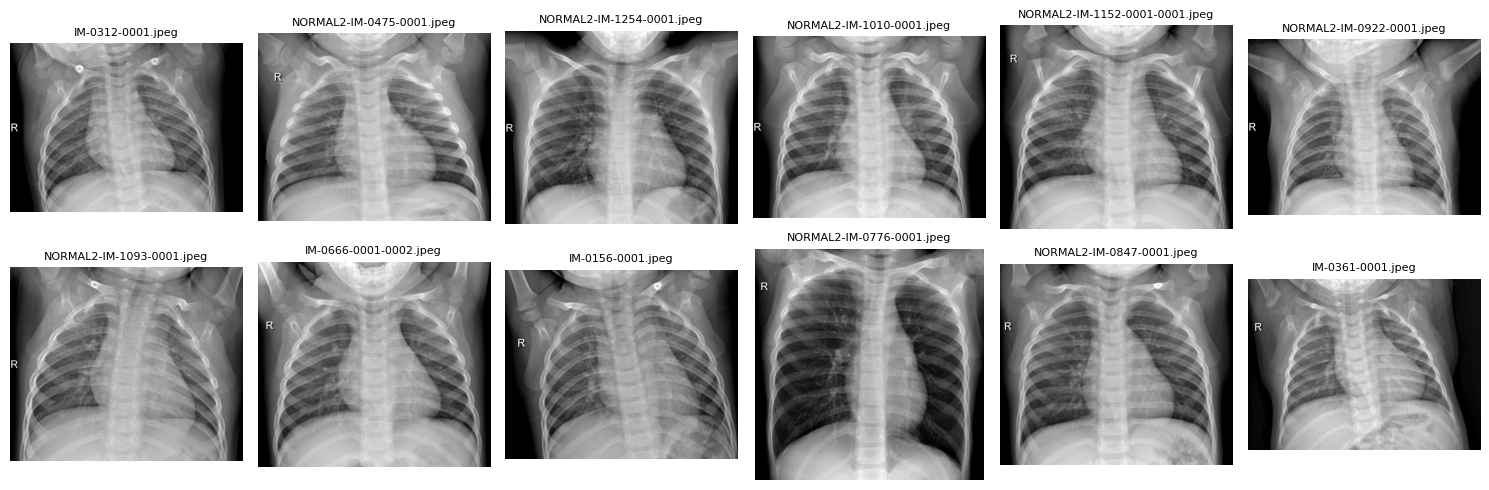

In [5]:
import os
import matplotlib.pyplot as plt

normal_folder_path = path+'/chest_xray/train/NORMAL'
images_name = os.listdir(normal_folder_path)
print(f'# NOrmal Images : {len(images_name)}')

fig, ax = plt.subplots(2, 6, figsize=(15, 5))
ax = ax.flatten()

for i in range(12):
    img_path = os.path.join(normal_folder_path, images_name[i])
    img = Image.open(img_path)
    ax[i].imshow(img , cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(images_name[i], fontsize=8)

plt.tight_layout()
plt.show()

## Get Ready for the Train (Data split)

In [6]:
train_path = path + '/chest_xray/train'
val_path = path + '/chest_xray/val'
test_path = path + '/chest_xray/test'

In [7]:
def get_images(path):
    X = []
    y = []
    for file in os.listdir(path):
        images = glob.glob(path + f'/{file}' + '/*')
        for image in images:
            image_array = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (150, 150))
            image_array = np.expand_dims(image_array, axis = -1)
            X.append(image_array)
            y.append(1 if file != 'NORMAL' else 0)
    return X, y

In [8]:
X_train, y_train = get_images(train_path)
X_val, y_val = get_images(val_path)
X_test, y_test = get_images(test_path)

In [9]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

<BarContainer object of 2 artists>

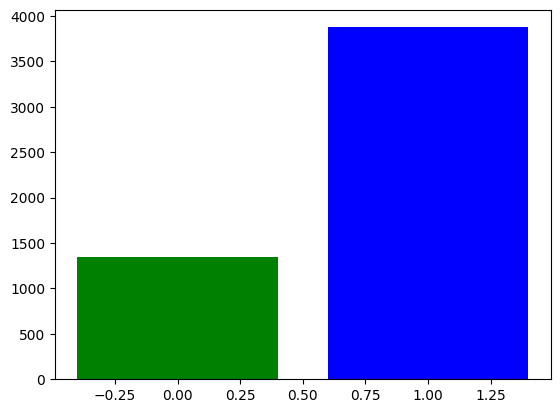

In [10]:
counts = Counter(y_train)
plt.bar(x = counts.keys(), height = counts.values(), color = ['b', 'g'])

In [11]:

X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

In [12]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [13]:
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range = 30,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

data_gen.fit(X_train)

In [14]:
import tensorflow
tensorflow.keras.backend.clear_session()

## Model 1

In [15]:
model_1 = Sequential()
model_1.add( Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 1)))
model_1.add( Conv2D(64, (3, 3), activation='relu'))
model_1.add( MaxPooling2D((2, 2)))
model_1.add( Conv2D(128, (3, 3), activation='relu'))
model_1.add( Conv2D(128, (3, 3), activation='relu'))
model_1.add( MaxPooling2D((2, 2)))
model_1.add( Conv2D(128, (3, 3), activation='relu'))
model_1.add( Conv2D(128, (3, 3), activation='relu'))
model_1.add( MaxPooling2D((2, 2)))
model_1.add( Conv2D(128, (3, 3), activation='relu'))
model_1.add( Conv2D(128, (3, 3), activation='relu'))
model_1.add( MaxPooling2D((2, 2)))
model_1.add( Flatten())
model_1.add( Dense(512, activation='relu'))
model_1.add( Dense(1, activation='sigmoid'))



model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,470,017 (9.42 MB)

 Trainable params: 2,470,017 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model_1.fit(data_gen.flow(X_train,y_train,batch_size = 32)
                      ,epochs=25,
                      validation_data =(X_val, y_val))

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - acc: 0.7334 - loss: 0.6070 - val_acc: 0.5000 - val_loss: 0.7495
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - acc: 0.7393 - loss: 0.5804 - val_acc: 0.5000 - val_loss: 0.8850
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - acc: 0.7362 - loss: 0.5803 - val_acc: 0.5000 - val_loss: 0.8456
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - acc: 0.7333 - loss: 0.5812 - val_acc: 0.5000 - val_loss: 0.8272
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - acc: 0.7284 - loss: 0.5916 - val_acc: 0.6250 - val_loss: 0.6770
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - acc: 0.7546 - loss: 0.5031 - val_acc: 0.6875 - val_loss: 0.5983
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - acc: 0.8216 - loss: 0.3995 - val_acc: 0.5625 - val_loss: 1.0481
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - acc: 0.8666 - loss: 0.3208 - val_acc: 0.8750 - val_loss: 0.5613
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 

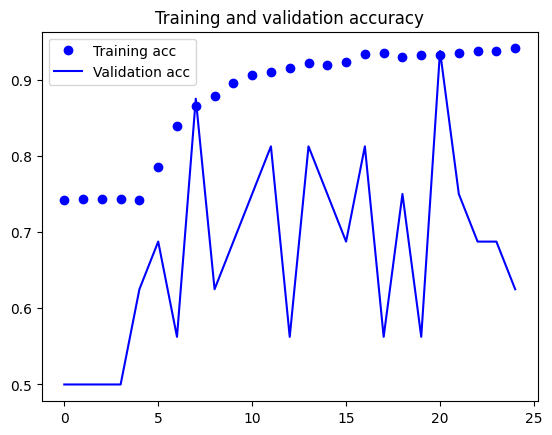

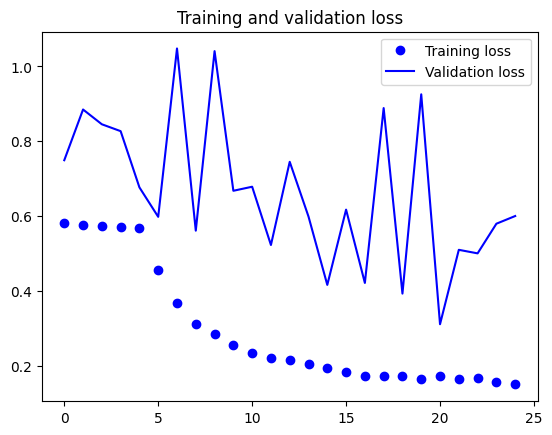

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
y_pred = model_1.predict(X_test)
y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_pred])

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [22]:
from sklearn.utils import compute_class_weight
class_weights = dict(zip(np.unique(y_train), compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

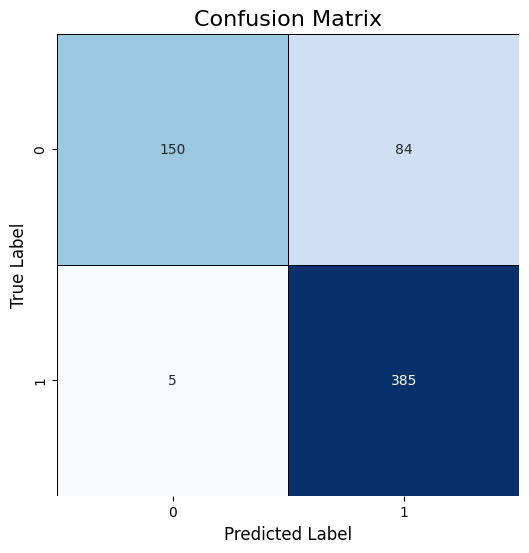

              precision    recall  f1-score   support

           0       0.97      0.64      0.77       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred))

# Model 2

In [26]:
model_2 = Sequential()
model_2.add( Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 1)))
model_2.add( Conv2D(64, (3, 3), activation='relu'))
model_2.add( AveragePooling2D((2, 2)))
model_2.add( Conv2D(128, (3, 3), activation='relu'))
model_2.add( Conv2D(128, (3, 3), activation='relu'))
model_2.add( AveragePooling2D((2, 2)))
model_2.add( Conv2D(128, (3, 3), activation='relu'))
model_2.add( Conv2D(128, (3, 3), activation='relu'))
model_2.add( AveragePooling2D((2, 2)))
model_2.add( Conv2D(128, (3, 3), activation='relu'))
model_2.add( Conv2D(128, (3, 3), activation='relu'))
model_2.add( AveragePooling2D((2, 2)))
model_2.add( Flatten())
model_2.add( Dense(512, activation='relu'))
model_2.add( Dense(1, activation='sigmoid'))



model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 71, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 69, 69, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 34, 34, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 30, 30, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 15, 15, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 13, 13, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 5, 5, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,470,017 (9.42 MB)

 Trainable params: 2,470,017 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model_2.fit(data_gen.flow(X_train,y_train,batch_size = 32)
                      ,epochs=25,
                      validation_data =(X_val, y_val))

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - acc: 0.7177 - loss: 0.6068 - val_acc: 0.5000 - val_loss: 0.7930
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - acc: 0.7418 - loss: 0.5734 - val_acc: 0.5000 - val_loss: 0.7367
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - acc: 0.7409 - loss: 0.5847 - val_acc: 0.5000 - val_loss: 0.8604
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - acc: 0.7475 - loss: 0.5662 - val_acc: 0.5000 - val_loss: 0.8335
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - acc: 0.7415 - loss: 0.5727 - val_acc: 0.5000 - val_loss: 0.8069
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - acc: 0.7444 - loss: 0.5705 - val_acc: 0.5000 - val_loss: 0.8065
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - acc: 0.7486 - loss: 0.5648 - val_acc: 0.5000 - val_loss: 0.8482
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - acc: 0.7485 - loss: 0.5646 - val_acc: 0.5000 - val_loss: 0.7792
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 

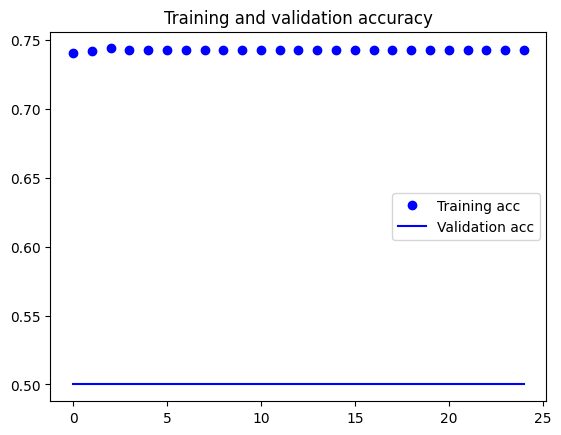

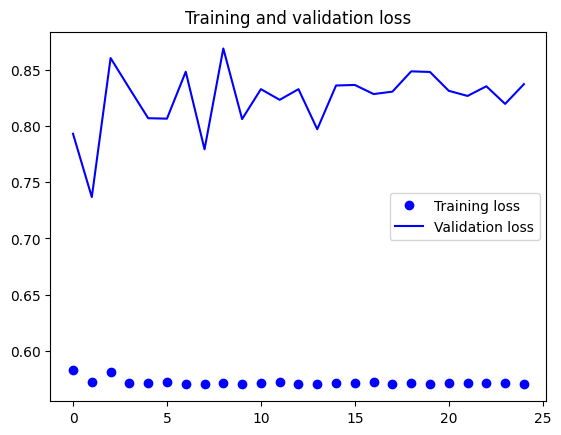

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
y_pred = model_2.predict(X_test)
y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_pred])

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


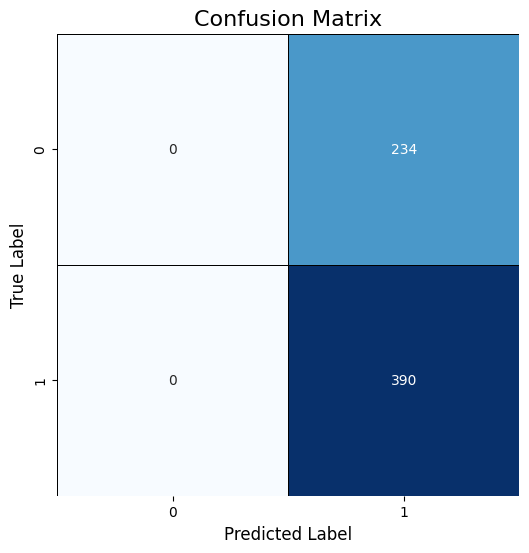

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred))

# Model 1 (Additional Train)

In [31]:
history = model_1.fit(data_gen.flow(X_train,y_train,batch_size = 32)
                      ,epochs=25,
                      validation_data =(X_val, y_val))

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - acc: 0.9474 - loss: 0.1373 - val_acc: 0.7500 - val_loss: 0.5729
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - acc: 0.9447 - loss: 0.1395 - val_acc: 0.6250 - val_loss: 0.5688
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - acc: 0.9434 - loss: 0.1460 - val_acc: 0.6250 - val_loss: 0.7301
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - acc: 0.9497 - loss: 0.1302 - val_acc: 0.8125 - val_loss: 0.3675
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - acc: 0.9447 - loss: 0.1451 - val_acc: 0.7500 - val_loss: 0.5143
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - acc: 0.9412 - loss: 0.1479 - val_acc: 0.7500 - val_loss: 0.4718
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - acc: 0.9513 - loss: 0.1297 - val_acc: 0.6875 - val_loss: 0.4347
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - acc: 0.9501 - loss: 0.1290 - val_acc: 0.5625 - val_loss: 1.2534
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 

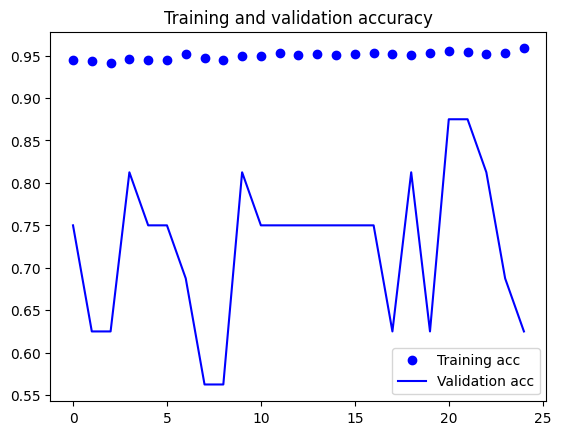

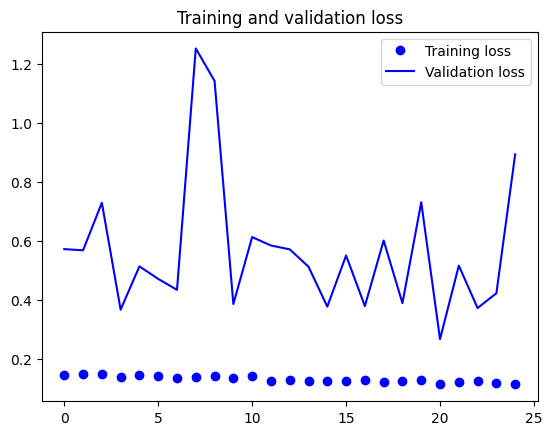

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
y_pred = model_1.predict(X_test)
y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_pred])

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


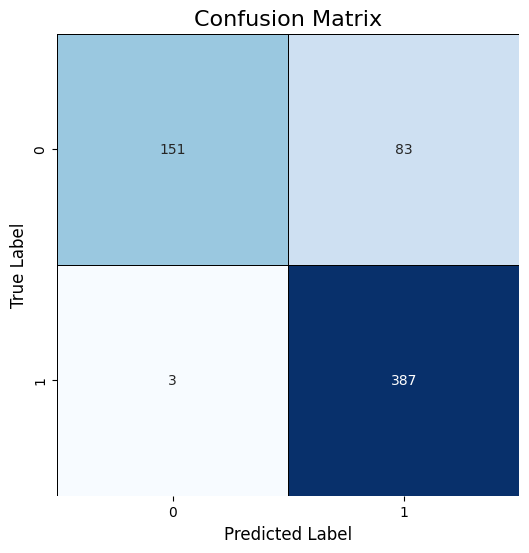

              precision    recall  f1-score   support

           0       0.98      0.65      0.78       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred))

#

# Model 3 (Skip Connection)

In [59]:
from keras import Input, Model
from keras.layers import Add, UpSampling2D, GlobalAveragePooling2D

In [60]:
input_layer = Input(shape=(150, 150, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
skip_1 = x

x = MaxPooling2D((2, 2))(x)

for _ in range(3):
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)  # 채널 수 맞추기
x = Add()([x, skip_1])

x = GlobalAveragePooling2D()(x)


x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=input_layer, outputs=output_layer)

model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['acc'])

model3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 150, 150, 32)   │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 150, 150, 64)   │         18,496 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 75, 75, 64)     │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 75, 75, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 75, 75, 128)    │        147,584 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 75, 75, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 75, 75, 128)    │        147,584 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 75, 75, 128)    │        147,584 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 75, 75, 128)    │        147,584 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 150, 150, 128)  │              0 │ conv2d_25[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 150, 150, 64)   │          8,256 │ up_sampling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 150, 150, 64)   │              0 │ conv2d_26[0][0],       │
│                           │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ add_2[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │         33,280 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            257 │ dense_2[0][0]          │
└──────────────────────

 Total params: 1,003,713 (3.83 MB)

 Trainable params: 1,003,713 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model3.fit(data_gen.flow(X_train,y_train,batch_size = 32)
                      ,epochs=25,
                      validation_data =(X_val, y_val))

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 229ms/step - acc: 0.7207 - loss: 0.5748 - val_acc: 0.5000 - val_loss: 0.8402
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - acc: 0.7342 - loss: 0.5777 - val_acc: 0.5000 - val_loss: 0.7370
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 199ms/step - acc: 0.7347 - loss: 0.4978 - val_acc: 0.5000 - val_loss: 0.7921
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 199ms/step - acc: 0.7409 - loss: 0.5737 - val_acc: 0.5000 - val_loss: 0.8059
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - acc: 0.7546 - loss: 0.5599 - val_acc: 0.5000 - val_loss: 0.7866
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - acc: 0.7478 - loss: 0.5654 - val_acc: 0.5000 - val_loss: 0.7979
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - acc: 0.7438 - loss: 0.5530 - val_acc: 0.5000 - val_loss: 0.7612
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - acc: 0.7481 - loss: 0.4684 - val_acc: 0.5000 - val_loss: 0.7552
Epoch 9/25
163/163 ━━━━━━━━━━━━━

KeyboardInterrupt: 

- 과적합임. BatchNorm 고려 가능할듯

# 모델 4